In [8]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import pdist, squareform
import shutil

import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import scipy
from pylab import rcParams

import community as community_louvain
import networkx as nx

from sklearn.metrics import silhouette_score

In [9]:
def build_blobs(N, k, sigma):
    '''
    Constructs a dataset of k Gaussian blobs with standard deviation sigma, evenly spaced along the unit circle.
    '''
    
    # Generates points
    rep = np.repeat(np.arange(k), int(N/k))
    remaining = np.arange(N - k*int(N/k))
    gt = np.append(rep, remaining)

    # Gets k points along unit circle
    xmeans = []
    ymeans = []
    for j in range(k):
        radians = j*2*np.pi/k 
        xmeans.append(np.cos(radians))
        ymeans.append(np.sin(radians))

    # Calculates coordinates for each cluster
    coords = np.zeros((N, 2))
    for i in range(N):
        idx = gt[i]-1
        coords[i,:] = np.random.normal((xmeans[idx], ymeans[idx]), sigma)# Create 2D point

    return coords, gt


def build_sbm(N, k, pij, pii, sigma):
    '''
    Constructs a graph with k clusters. Points have an edge with probability pii if they are in the same cluster,
    and pij if they are not. For visualizations, the points are also given coordinates in Gaussian blobs.
    '''
    
    # Assigns k labels to points by repetition
    rep = np.repeat(np.arange(k), int(N/k))
    remaining = np.arange(N - k*int(N/k))
    gt = np.append(rep, remaining)
    
    # Randomly places edges
    A = np.zeros((N,N))
    for i in range(N):
        for j in range(i, N):
            unif = np.random.uniform()
            if gt[i] == gt[j]:
                if  unif < pii:
                    A[i,j] = 1
            else:
                if unif < pij:
                    A[i,j] = 1
    # Symmetrizes
    A = np.maximum(A, A.transpose())
    
    # Gets k points along unit circle
    rads = [j*2*np.pi/k for j in range(k)]
    xmeans = [np.cos(r) for r in rads]
    ymeans = [np.sin(r) for r in rads]

    # Calculates coordinates for each cluster
    coords = np.zeros((N, 2))
    for i in range(N):
        idx = gt[i]-1
        coords[i,:] = np.random.normal((xmeans[idx], ymeans[idx]), sigma)
        
    return A, gt, coords


In [10]:
def compute_distance_matrix(coords):
    D = squareform(pdist(coords, metric='euclidean'))
    return D

def compute_affinity_matrix(D, sigma=None, k=None):
    '''
    Computes an affinity matrix from the n x n distance matrix D. 
    The user must specify either sigma or k, but not both. 
    sigma is the bandwidth parameter for our gaussian distribution. 
    k sets this bandwidth to the average distance from a point to its k'th nearest neighbor. 
    Recommendation: set k=10.
    '''
    n = D.shape[0]
    if k==None and sigma==None:
        print("Need to input either k or sigma.")
        return -1
    if k==None and sigma <= 0:
        print("sigma must be a positive number")
        return -1
    if k <= 0:
        print("k must be a small positive number, e.g. 10.")
    if sigma==None:
        # Sigma is mean distance to k'th nearest neighbor
        sigma = np.mean(np.sort(D, axis=1)[:,k])
    Aff = np.exp(-(D**2)/sigma)

    return Aff

In [11]:
def space_laser(A, flints, labels):
    '''
    The space laser zaps a tree (a point) from which a fire spreads. We call this point the "flint."
    '''
    
    N = A.shape[0]
    # Sums all affinities for each point
    sum_affinities = np.sum(A, axis=1)
    if len(flints)==0:
        max_affinity = np.max(sum_affinities)
        flint = np.where(sum_affinities==max_affinity)[0][0]

    else:
        min_aff = sys.maxsize
        flint = -1
        dists = []
        for i in range(N):
            if labels[i]==-1:# Point unburnt
                # distance to nearest cluster centroid
                val = max([A[i, centroid_idx] for centroid_idx in flints])
                dists.append(val)
            else:
                dists.append(-1)
    
        dists = np.array(dists)
        pos_dists = dists[dists > 0]
        if len(pos_dists)==0:# Happens when distances have numerical underflow
            # select first unburnt element
            flint = np.where(labels==-1)[0][0]
        else:
            # Only consider points far from existing centroids
            bounds = np.quantile(pos_dists, [0, 0.25])
            # Indices of dists whose values are within bounds
            idx = np.where((dists >= bounds[0]) * (dists < bounds[1]))[0]
            if idx.size==0:
                flint = np.where(labels==-1)[0][0]
            else:
                # Choose point with highest affinity 
                max_good_aff = np.max(sum_affinities[idx])
                max_good_aff_idx = np.where(sum_affinities==max_good_aff)[0]
                for i in range(max_good_aff_idx.shape[0]):
                    if max_good_aff_idx[i] in idx:
                        flint = max_good_aff_idx[i]# If multiple candidates, takes first unburnt point
                        break          
    return flint
            
    
def relabel(bad_idx, large_clusters, labels, A):
    '''
    Relabels point that were either never burnt or burnt to a small cluster to a larger one. 
    
    bad_idx contains indices of points to re-label; large_clusters contains the larger clusters' labels. 
    '''
    
    n_bad = bad_idx.shape[0]
    new_labels = np.copy(labels)
    for i in range(n_bad):
        idx = bad_idx[i]
        # Calculate heat from a cluster
        reassignment = -1
        max_heat = -1
        for j in large_clusters: 
            heat = np.mean(A[idx, labels==j])
            if heat > max_heat:# Choose cluster producing max heat
                max_heat = heat
                reassignment = j
        new_labels[idx] = reassignment
    return new_labels


def remap(labels):
    '''
    The model's k labels may be non-consecutive. remap() maps these labels to {0, 1, 2, ..., k-1}
    '''
    
    new_labels = np.repeat(-1, labels.shape[0]) # initialize
    clusters = np.unique(labels)
    k_model = clusters.shape[0]
    for i in range(k_model):
        # Put elements in order
        idx = labels==clusters[i]
        new_labels[idx] = i
    return new_labels

In [36]:
def remove_small_clusters(k, labels, A, min_cluster_size, min_size_ratio, verbose):
    '''
    Removes small clusters from labels. Does not need the true number of clusters to be known.
    '''
    
    clusters, counts = np.unique(labels, return_counts=True)
    k_model = clusters.shape[0]
    # Biggest to smallest
    clusters_sorted_by_size = np.argsort(counts)[::-1]
    counts_sorted_by_size = np.sort(counts)[::-1]
    
    # If unburnt points exist, label them to existing clusters
    if clusters[0]==-1:
        is_unburnt = np.array(labels==-1)# T/F array
        unburnt_idx = np.argwhere(is_unburnt==True)# Indices
        labels = relabel(unburnt_idx, clusters[1:], labels, A)# Relabel

        # Reset clusters and counts
        clusters, counts = np.unique(labels, return_counts=True)
        k_model = clusters.shape[0]
        clusters_sorted_by_size = np.argsort(counts)[::-1]
        counts_sorted_by_size = np.sort(counts)[::-1]
    
    if k:
        if k_model <= k:
            if k_model < k and verbose:
                print('Inputted that the data has %d clusters, '\
                'but our model only burnt %d clusters.' % (k, k_model))
            return remap(labels)
        else:
            # relabels points in smallest clusters if more than k clusters were burnt
            large_clusters = clusters_sorted_by_size[:k]
            bad_output_indices = np.array([label not in large_clusters for label in labels])# T/F array
            bad_idx = np.argwhere(bad_output_indices==True)
            if verbose:
                print('Model burnt {} clusters. relabeling {} points to k={} biggest clusters.'
                      .format(k_model, bad_idx.shape[0], k))

            new_labels = relabel(bad_idx, large_clusters, labels, A)
            return remap(new_labels)
    
    else:
        # Number of clusters is not known
        large_clusters = None
        if min_cluster_size:
            try:
                large_clusters = clusters_sorted_by_size[counts_sorted_by_size > min_cluster_size]
            except:
                print('min_cluster_size must be a positive number. Ignoring.')
            if large_clusters.size==0:
                print('min_cluster_size is too small. Ignoring.')
    
        if min_size_ratio > 0:
            for i in range(clusters.shape[0]-1):
                cluster_size_1 = counts[clusters_sorted_by_size[i]]
                cluster_size_2 = counts[clusters_sorted_by_size[i+1]]
                if cluster_size_2 < min_size_ratio*cluster_size_1:
                    if large_clusters is not None:
                        large_clusters = clusters_sorted_by_size[:i+1]
                    else:
                        # Merge the two
                        large_clusters = np.intersect1d(large_clusters, clusters_sorted_by_size[:i+1])
                    break
                        
        if large_clusters is not None:
            # relabel points in all smaller clusters 
            n_large_clusters = large_clusters.shape[0]
            if n_large_clusters < k_model:
                bad_output_indices = np.array([label not in large_clusters for label in labels])
                bad_idx = np.argwhere(bad_output_indices==True)
                if verbose:
                    words = 'cluster is' if n_large_clusters==1 else 'clusters are'
                    pronoun = 'it' if n_large_clusters==1 else 'them'
                    print('%d %s too small; relabeling the %d points in %s. Final model contains %d clusters.'\
                          % (k_model - n_large_clusters, words, bad_idx.shape[0], pronoun, n_large_clusters))
                labels = relabel(bad_idx, large_clusters, labels, A)
                    
        return remap(labels)
    

In [37]:
def forest_fire_clustering(A, fire_temp, k=None, n_before_break=200, visualization_coords=None, min_size_ratio=0.0, min_cluster_size=None, verbose=False):
    '''
    Forest Fire Clustering (by Flynn Chen & Jeremy Goldwasser)

    Inputs:
        A   (N x N np.ndarray): Affinity or Adjacency Matrix of graph

    Outputs:
        labels (n x 1 np.ndarray): Output cluster labels
    '''

    # initialization    
    N = A.shape[0] #the number of entries/data points
    labels = -np.ones(N) #a list of labels for each point
    n_unburnt = N
    label_number = 0# label_number is the current cluster label we're assigning points
    flints = []
    cdict = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'green', \
        4: 'purple', 5: 'orange', 6: 'magenta', 7: 'black', \
        8: 'brown', 9: 'maroon', 10: 'gray', 11: 'cyan', \
        12: 'beige', 13: 'lime', 14: 'turquoise', 15: 'navy', \
        16: 'pink', 17: 'silver', 18: 'indigo', 19: 'tan'}
    
#     avg_degree = np.mean(np.sum(A, axis=1))
#     threshold = 1 / avg_degree
    threshold = 1

    while n_unburnt > 0: #iterate until there is a label for each point
        flint = space_laser(A, flints, labels)
        n_unburnt -= 1
        labels[flint] = label_number
        if n_unburnt == 0:
            break
        
        flints.append(flint)
        spreading = True
        # Order points by distance to cluster centroid
        affinities_to_centroid = A[:, flint]
        ordered_points = np.argsort(affinities_to_centroid)[::-1]
        while spreading:
            spreading = False
            n_no_adds = 0
            for idx in ordered_points:
                if labels[idx] == -1:
                    # Heat at point given by mean affinity with points in burning cluster
                    heat = fire_temp*np.mean(A[idx, labels==label_number])
                    if heat > threshold:
                        spreading = True
                        n_unburnt -= 1
                        labels[idx] = label_number
                        n_no_adds = 0
                    else:
                        n_no_adds += 1
                        if n_no_adds==n_before_break:
                            break
                        
        label_number += 1
        
        if visualization_coords is not None:           
            unburnt_ix = np.where(labels==-1)
            plt.scatter(visualization_coords[unburnt_ix,0], visualization_coords[unburnt_ix,1], facecolors='none', edgecolors='black', s=25)
            # Display all burnt clusters
            if label_number <= 20:# Can use nice color dict
                for g in range(label_number):
                    ix = np.where(labels==g)
                    plt.scatter(visualization_coords[ix,0], visualization_coords[ix,1], c=cdict[g], s=25)
            else:
                burnt_ix = np.where(labels!=-1)
                plt.scatter(visualization_coords[burnt_ix,0], visualization_coords[burnt_ix,1], c=labels[burnt_ix], s=25)
            
            plt.scatter(visualization_coords[flints,0], visualization_coords[flints,1], c='black', edgecolors='white', s=200, marker='*')

            word1 = 'cluster' if label_number==1 else 'clusters'
            word2 = 'point' if n_unburnt==1 else 'points'
            plt.title('%d %s burnt. %d %s remain.'%(label_number, word1, n_unburnt, word2))
            plt.show()
            
        if k:
            # K clusters have been burnt, and points remain unburnt
            if label_number >= k and n_unburnt > 0:
                clusters, counts = np.unique(labels, return_counts=True)# includes -1
                n_in_kth_largest = np.sort(counts[1:])[-k]
                # All future clusters will inevitably be relabled due to size
                if n_unburnt < n_in_kth_largest:
                    break
        # If few points remaining, relabel points not in k largest clusters
#         if k:
#             if label_number >= k and n_unburnt > 0:
#                 clusters, counts = np.unique(labels, return_counts=True)# includes -1

#                 n_in_kth_largest = np.sort(counts[1:])[-k]
#                 if n_unburnt < n_in_kth_largest:
#                     # Label the unburnt points to the largest clusters
#                     large_clusters = np.argsort(counts[1:])[-k:]# Indices of counts (excluding -1) of k biggest clusters
#                     bad_output_indices = np.array([label not in large_clusters for label in labels])# T/F array
#                     bad_idx = np.argwhere(bad_output_indices==True)
#                     labels = relabel(bad_idx, large_clusters, labels, A)
#                     break
        # Don't bother labeling unburnt points to small clusters
        if min_cluster_size:
            try:
                if n_unburnt < min_cluster_size:
                    break
            except:
                print('min_cluster_size must be a positive number. Setting to None.')
    
    labels_without_small_clusters = remove_small_clusters(k, labels, A, min_cluster_size, min_size_ratio, verbose)
    return labels_without_small_clusters


In [31]:
def display_outputs_and_gt(coords, gt, labels, k_known, title=None, compute_accuracy=True, score=None, s=15):
    '''
    Makes side-by-side plots of points colored by model and ground truth labels.
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    if title:
        ttl = fig.suptitle(title, fontsize=20)
        ttl.set_position([.5, 1.05])
    Str = 'K Known' if k_known else 'K Unknown'
    text1 = 'Forest Fire Labels, ' + Str
    newline = False
    if compute_accuracy:
        N = labels.shape[0]
        pct_correct = np.sum(labels == gt)/N*100
        text1 += '\n ' + str(round(pct_correct, 1)) + "% Accuracy"
        newline = True
    if score is not None:
        text1 += '. ' if newline else '\n'
        text1 += 'Silhouette Score=' + str(round(score, 2))
    
    cdict = {0: 'yellow', 1: 'red', 2: 'blue', 3: 'green', \
             4: 'purple', 5: 'orange', 6: 'magenta', 7: 'black', \
             8: 'brown', 9: 'maroon', 10: 'gray', 11: 'cyan', \
            12: 'beige', 13: 'lime', 14: 'turquoise', 15: 'navy', \
            16: 'pink', 17: 'silver', 18: 'indigo', 19: 'tan'}
    k_model = np.unique(labels).shape[0]
    k_gt = np.unique(gt).shape[0]
    max_n_clusters = max(k_model, k_gt)
    if max_n_clusters < len(cdict.keys()):
        for g in range(max_n_clusters):
            ix1 = np.where(labels == g)
            ax1.scatter(coords[ix1,0], coords[ix1,1], c=cdict[g], label=g, s=s)

            ix2 = np.where(gt == g)
            ax2.scatter(coords[ix2,0], coords[ix2,1], c=cdict[g], label=g, s=s)
    else:
        ax1.scatter(coords[:,0], coords[:,1], c=labels, cmap='twilight_shifted_r', s=s)
        ax2.scatter(coords[:,0], coords[:,1], c=gt, cmap='twilight_shifted_r', s=s)
    
    ax1.set_title(text1)
    ax2.set_title('Ground Truth Labels')
    plt.show()    

In [15]:
def cluster_new_points(old_data, new_data, labels, fire_temp, interconnections=None, kernel_type='gaussian', k_affinity=None, sigma_affinity=None):
    '''
    Assigns new points - represented by either spatial coordinates or adjacency lists - to existing model clusters.
    '''
    
    N = labels.shape[0]
    n_new = new_data.shape[0]
    bad_idx = np.array(range(N, N+n_new))
    new_labels = np.concatenate((labels, np.repeat(-1, n_new)))# Initialize new array
    large_clusters = np.unique(labels)
    
    if np.array_equal(np.unique(old_data), [0,1]):# old_data is adjacency matrix
        # Builds adjacency matrix. new_data only contains edges with the N existing points
        A_new = np.zeros((N+n_new, N+n_new))
        A_new[:N, :N] = old_data
        A_new[N:, :N] = new_data
        A_new[:N, N:] = np.transpose(new_data)
        if interconnections is not None:
            if interconnections.shape==(n_new, n_new):
                A_new[N:, N:] = interconnections
    else:
        # Builds new distance and affinity matrix
        all_data_new = np.concatenate((old_data, new_data))
        D_new = compute_distance_matrix(all_data_new)
        A_new = compute_affinity_matrix(D_new, k=k_affinity, sigma=sigma_affinity)
    
    # Assigns new points to clusters
    new_labels = relabel(bad_idx, large_clusters, new_labels, A_new)
    return new_labels, A_new


In [16]:
def get_counts(values, k):
    # Gets length-k vector of counts
    unique_labels, counts = np.unique(values, return_counts=True)
    if counts.shape[0]==k:
        return counts
    full_counts = np.zeros(k)
    count = 0
    for x in range(k):
        if x in unique_labels:
            full_counts[x] = counts[count]
            count += 1
    return full_counts


def align_labels(gt, labels, return_mapping=False): 
    '''
    Finds the optimal alignment between cluster labels in the model and the ground truth. 
    Each model label - say, 'i' - likely corresponds with a different ground truth label 'j'.
    We should pick 'j' such that most of the points the model puts in cluster i belong in 'j.'
    We also want for most of the points in j to be labeled by the model as in 'i.'
    
    '''
    clusters_gt, gt_counts = np.unique(gt, return_counts=True)
    clusters_model, label_counts = np.unique(labels, return_counts=True)
    k_gt = clusters_gt.shape[0]
    k_model = clusters_model.shape[0]
    N = np.shape(gt)[0]
    
    P_gt_given_label = np.zeros((k_model, k_gt))
    P_label_given_gt = np.zeros((k_gt, k_model))
    for i in range(k_model):
        # calculates probability of gt class for a point labeled "i"
        gt_with_label = gt[labels==i]
        gt_counts_for_label = get_counts(gt_with_label, k_gt)
        P_gt_given_label[i,:] = gt_counts_for_label / gt_with_label.shape[0]

    for j in range(k_gt):    
        # calculates probabilities of model labels for a point in class j
        labels_with_gt = labels[gt==j]
        label_counts_for_gt = get_counts(labels_with_gt, k_model)
        P_label_given_gt[j,:] = label_counts_for_gt / labels_with_gt.shape[0]

    mapping = np.repeat(-1, k_model)
    best_scores = []
    for i in range(k_model):
        # for each output label i, choose gt class j that maximizes P(y_j|yhat_i)*P(yhat_i|y_j)
        # where y is true class label and y_hat is predicted class label
        scores = []
        for j in range(k_gt):
            # Scores each class for a given i
            scores.append(P_gt_given_label[i,j]*P_label_given_gt[j,i])
        mapping[i] = np.argmax(scores)# mapping[i] = j that maximizes score for label i
        best_scores.append(np.amax(scores))
    best_scores = np.array(best_scores)
    mapped_labels = np.repeat(-1, N)# initialize
    
    mapped_to_clusters, times_mapped_to = np.unique(mapping, return_counts=True)
    if k_model > mapped_to_clusters.shape[0]:
        # At least one gt cluster is mapped to by 2+ model labels
        duplicated_gt = mapped_to_clusters[np.argwhere(times_mapped_to > 1)]
        count = 0
        for i in range(duplicated_gt.shape[0]):
            gt_cluster = duplicated_gt[i]
            # Find labels that map to this cluster
            labels_mapping_to_cluster = np.argwhere(mapping==gt_cluster).reshape(-1)
            # Find those labels' scores with gt_cluster
            highest_score_idx = np.argmax(best_scores[labels_mapping_to_cluster])
            best_label = labels_mapping_to_cluster[highest_score_idx]# Label with highest score
            bad_labels = np.delete(labels_mapping_to_cluster, highest_score_idx)
            
            n_mapped_to = np.unique(mapping).shape[0]
            for bad_label in bad_labels:
                # Change mapping for model labels with lower scores
                # We want each of these model labels to map to a different gt label
                if n_mapped_to >= k_gt:
                    mapping[bad_label] = k_gt + count# WRONG. CHANGE TO MISSING POINTS
                    count += 1
                else:
                    # Find which gt labels have not been mapped to 
                    unmapped_to_labels = np.delete(np.arange(k_gt), np.unique(mapping))
                    # Calculate the score from bad_label to each label
                    scores = []
                    for j in unmapped_to_labels:
                        # Scores each class for a given i
                        scores.append(P_gt_given_label[bad_label,j]*P_label_given_gt[j,bad_label])
                    # Choose gt label that maximizes score for bad_label
                    mapping[bad_label] = unmapped_to_labels[np.argmax(scores)]
                    n_mapped_to += 1

    for i in range(k_model):
        idx = labels==i
        mapped_labels[idx] = mapping[i]
    if return_mapping:
        return mapped_labels, mapping
    
    return mapped_labels        


In [17]:
def monte_carlo_verification(labels, A, fire_temp=1, num_permute=200, n_before_break=200):
    
    # initialization
    N = A.shape[0]
    monte_carlo_labels = -np.ones((num_permute,N))
    start_time = time.time()
    checkpoint = -1
    avg_degree = np.mean(np.sum(A, axis=1))
    threshold = 1 / avg_degree
    for p in range(num_permute): #perform permutation test
        if p % (num_permute/10)==0:
            if p==num_permute/10:
                checkpoint = time.time() - start_time
            if checkpoint > 1:
                print('Iteration {}/{}. Time elapsed: {} seconds'.format(p, num_permute, round(time.time()-start_time, 2)))
        # Randomly permute clusters
        random_label_order = np.unique(labels)
        np.random.shuffle(random_label_order)
        for label_number in random_label_order:
            # Randomly select a flint from the cluster
            cluster_node_idx = np.where(labels == label_number)[0]
            flint = np.random.choice(cluster_node_idx, 1)[0]

            monte_carlo_labels[p, flint] = label_number            
            spreading = True
            # Order points by distance to cluster centroid
            affinities_to_centroid = A[:, flint]
            decreasing_order = np.argsort(affinities_to_centroid)[::-1]
            while spreading:
                spreading = False
                n_no_adds = 0
                for idx in decreasing_order:
                    if monte_carlo_labels[p,idx] == -1:
                        heat = fire_temp*np.mean(A[idx, monte_carlo_labels[p,:]==label_number])
                        if heat > threshold:
                            spreading = True
                            # Change label of newly lit point from -1 to label_number
                            monte_carlo_labels[p, idx] = label_number
                            n_no_adds = 0
                        else:
                            n_no_adds += 1
                            if n_no_adds==n_before_break:
                                break

    return monte_carlo_labels


In [18]:
def display_entropy(monte_carlo_labels, coords, return_entropy=False, s=15):
    rcParams['figure.figsize'] = 6, 5

    entropy_list = []
    for i in range(monte_carlo_labels.shape[1]): #iterate over every data point
        data_labels = monte_carlo_labels[:, i]
        labeled_data = data_labels[data_labels >= 0].astype(int)
        # Probability distribution of point's labels
        spread = np.bincount(labeled_data) / np.shape(labeled_data)[0]
        node_entropy = scipy.stats.entropy(spread)# Computes entropy
        entropy_list.append(node_entropy)
    entropy_list = np.array(entropy_list)
    plt.scatter(coords[:,0], coords[:,1], c=entropy_list, s=s);
    plt.title("Entropy of Predicted Labels", fontsize=16)
    plt.colorbar()
    plt.show()
    if return_entropy:
        return entropy_list

    
def display_p_values(monte_carlo_labels, labels, coords, return_pvals=False, s=15):
    pval_list = []
    for i in range(monte_carlo_labels.shape[1]): #iterate over every data point
        data_labels = monte_carlo_labels[:, i]
        labeled_data = data_labels[data_labels >= 0].astype(int)
        if len(labeled_data)>0:
            # Probability that re-simulated label is different from original
            pval = np.mean(labeled_data != labels[i])
            pval_list.append(pval)
        else:
            pval_list.append(0.0)

    pval_list = np.array(pval_list)
    plt.scatter(coords[:,0], coords[:,1], c=pval_list, s=s);
    plt.title("P-value of Predicted Labels", fontsize=16)
    plt.colorbar()
    plt.show()
    if return_pvals:
        return np.array(pval_list)

def print_alternate_clusters(original_labels, monte_carlo_labels, unstable_idx):
    '''
    For each cluster, shows which other labels its points correspond to.
    '''

    # Labels of those points
    unstable_clusters = np.unique(original_labels[unstable_idx])
    k_model = np.unique(original_labels).shape[0]
    for j in range(unstable_clusters.shape[0]):
        label = unstable_clusters[j]

        unstable_pts = unstable_idx[original_labels[unstable_idx]==label]
        print('{} unstable points originally labeled in Cluster #{}'.format(unstable_pts.shape[0], label))
        counts = {i:0 for i in range(k_model)}
        for pt in unstable_pts:
            perm_rows = monte_carlo_labels[:,pt] != -1# Rows in monte carlo where label assigned
            perm_clusters, perm_counts = np.unique(monte_carlo_labels[perm_rows,pt], return_counts=True)    
            for i in range(perm_clusters.shape[0]):
                if perm_clusters[i] != label:# Only consider wrong labels
                    counts[perm_clusters[i]] += perm_counts[i]
        denom = sum(counts.values())
        pct_mislabeled = [counts[i]/denom*100 for i in range(k_model)]

        for i in range(k_model):
            if pct_mislabeled[i] > 0:
                print('  - {}% of different labelings to Cluster #{}'.format(round(pct_mislabeled[i]), i))
        if j < unstable_clusters.shape[0]-1:
            print('-'*20)


In [19]:
def display_alternate_clusters(labels, cluster, unstable_idx, monte_carlo_labels, X):
    # Gets all labels for an unstable point originally in largest cluster
    pt = unstable_idx[labels[unstable_idx]==cluster][0]
    perm_rows = monte_carlo_labels[:,pt] != -1

    cdict = {0: 'orange', 1: 'red', 2: 'silver', 3: 'green',
             4: 'pink', 5: 'violet', 6: 'lime', 7: 'tan',
             8: 'brown', 9: 'maroon', 10: 'gray', 11: 'cyan',
             12: 'beige'}

    # Clusters
    clusters = np.unique(labels)

    # Gets counts of permuted labels
    perm_clusters = np.unique(monte_carlo_labels[perm_rows,pt])    
    x = 0

    for i in range(clusters.shape[0]):
        label = clusters[i]
        if label in perm_clusters and label != cluster:
            plt.scatter(X[labels==label, 0], 
                        X[labels==label, 1], 
                        c=cdict[x], s=15)
            x += 1
        elif label==cluster:
            plt.scatter(X[labels==label, 0], 
                        X[labels==label, 1], 
                        c='black', s=15)
        else:
            plt.scatter(X[labels==label, 0], 
                        X[labels==label, 1], 
                        facecolors='white', edgecolors='blue', s=1)

    plt.scatter(X[pt,0], X[pt,1], facecolors='gray', edgecolors='white', s=500, marker='*')
    colors = list(cdict.values())[:x]
    str = ', '.join(colors[:-1])
    if len(str)>0:
        word = 'clusters'
        str += ', and ' + colors[-1]
    else:
        word = 'cluster'
        str = colors[-1]
    print('Unstable cluster shown in black.')
    print('In Monte Carlo, the point marked with a star was frequently labeled in %s shown in %s.' % (word, str))
    print('All other clusters shown in blue.')
    plt.show()

Loading dataset


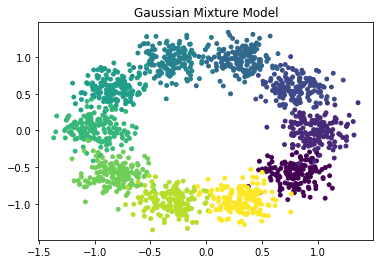

In [20]:
# Creates or loads coordinate data
k_gmm = 10
N_gmm = 1500

path = 'Datasets/GMM/' + str(k_gmm) + '_clusters_' + str(N_gmm) + '/'
coords_name = path + 'coords.npy'
gt_name = path + 'gt.npy'
D_name = path + 'D.npy'
A_name = path + 'A.npy'
if os.path.exists(coords_name) and os.path.exists(gt_name) and os.path.exists(D_name) and os.path.exists(A_name):
        print('Loading dataset')
        coords_gmm = np.load(coords_name)
        gt_gmm = np.load(gt_name)
        D_gmm = np.load(D_name)
        Aff_gmm = np.load(A_name)
else:
    print('Constructing Gaussian Mixture Model with %d points and %d clusters' % (N_gmm, k_gmm))
    coords_gmm, gt_gmm = build_blobs(N_gmm, k_gmm, sigma=0.05)    
    D_gmm = compute_distance_matrix(coords_gmm)
    start = time.time()
    Aff_gmm = compute_affinity_matrix(D_gmm, k=10)

    # Saves
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    with open(coords_name, 'wb') as f1:
        np.save(f1, coords_gmm)
    with open(gt_name, 'wb') as f2:
        np.save(f2, gt_gmm)
    with open(D_name, 'wb') as f3:
        np.save(f3, D_gmm)
    with open(A_name, 'wb') as f4:
        np.save(f4, Aff_gmm)

plt.title('Gaussian Mixture Model')
plt.scatter(coords_gmm[:,0],coords_gmm[:,1], c=gt_gmm, s=15)
plt.show()

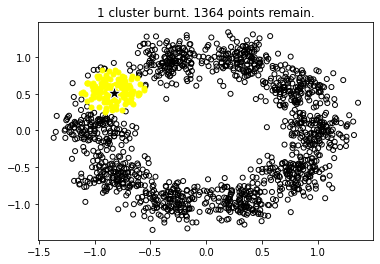

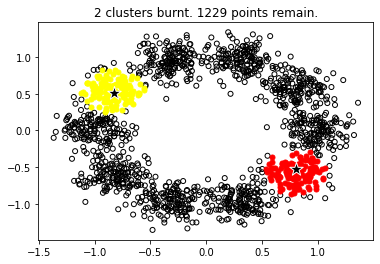

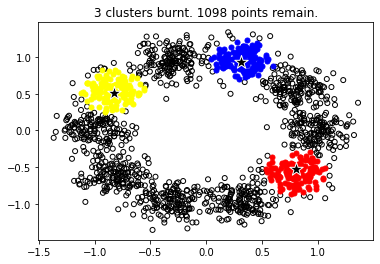

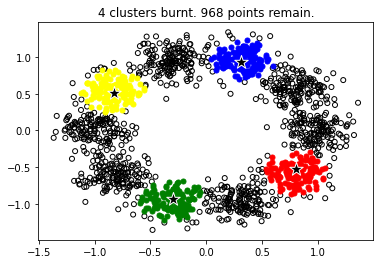

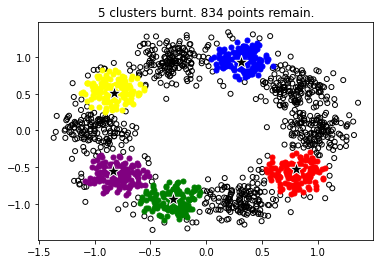

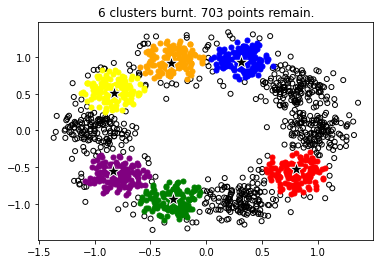

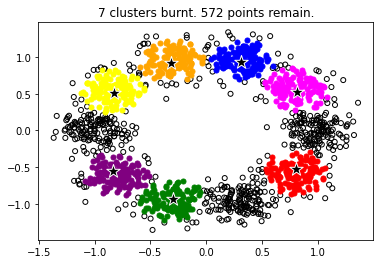

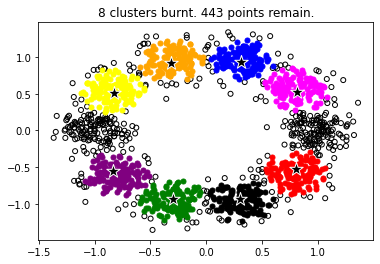

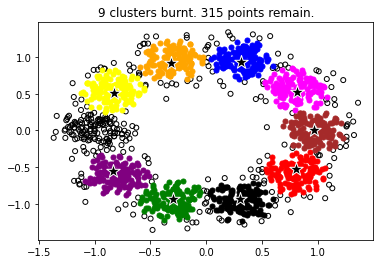

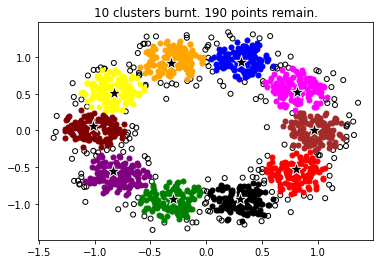

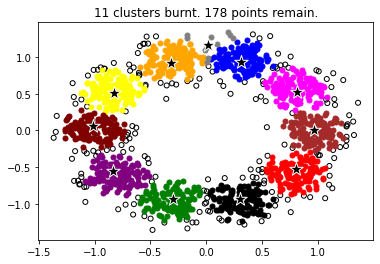

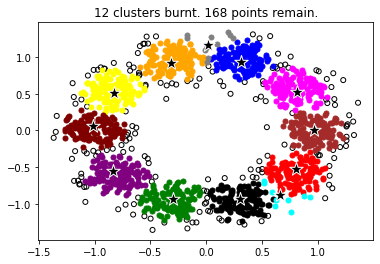

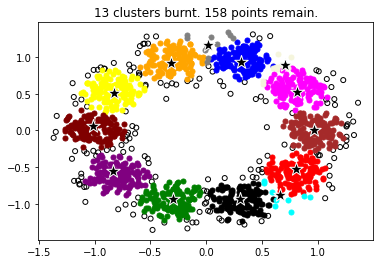

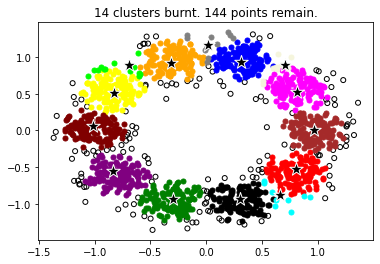

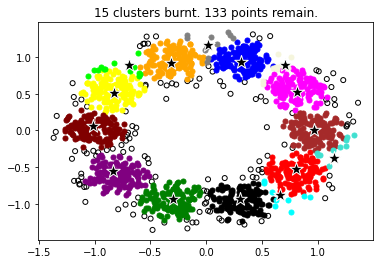

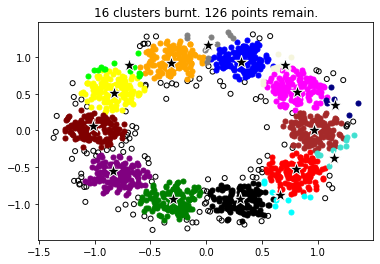

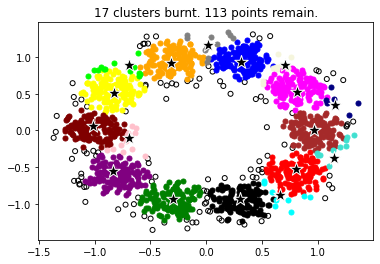

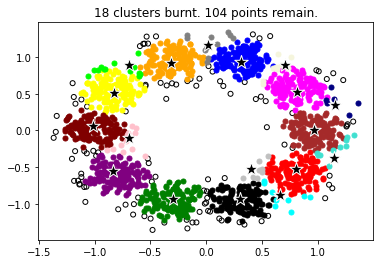

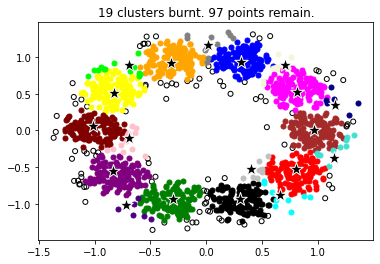

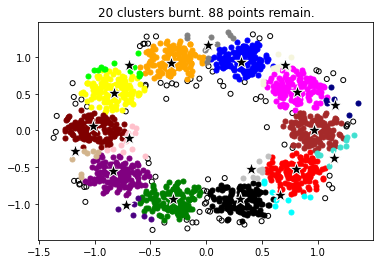

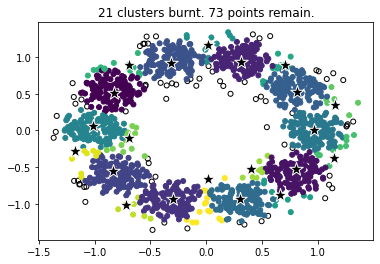

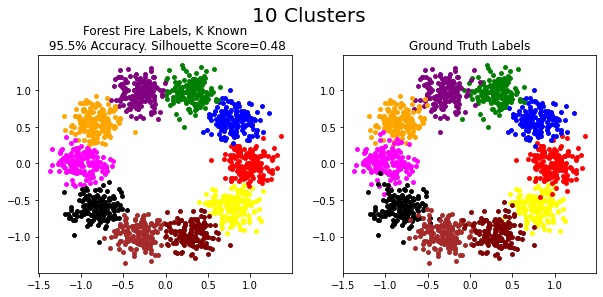

In [42]:
# Visualizing training
title = str(k_gmm) + ' Clusters'
labels_k_known = forest_fire_clustering(Aff_gmm, fire_temp=.025, k=None, n_before_break=200, visualization_coords=coords_gmm, min_cluster_size=50)
mapped_labels_k_known = align_labels(gt_gmm, labels_k_known)
score_k_known = silhouette_score(D_gmm, mapped_labels_k_known)
display_outputs_and_gt(coords_gmm, gt_gmm, mapped_labels_k_known, k_known=True, title=title, score=score_k_known)


Burning clusters, true k known


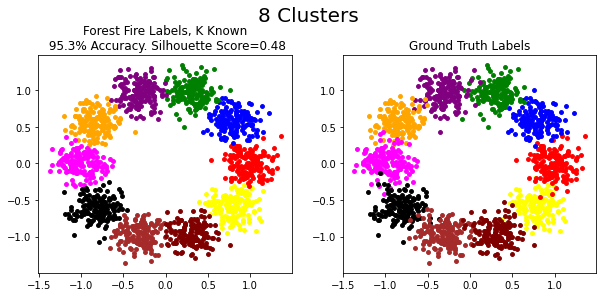


Burning clusters, true k unknown. min_cluster_size=10, min_size_ratio=0.1


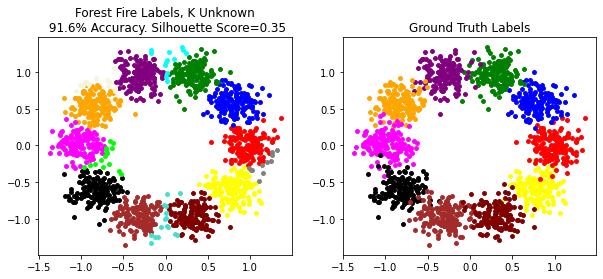


Burning clusters, true k unknown. min_cluster_size=20, min_size_ratio=0.2


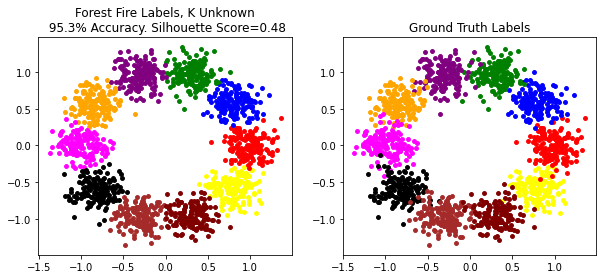

In [18]:
# N=500
    #k=5: anything 1 or under
    #k=8: .1 (.05 ok)
    #k=10: .05 (.1 ok)
#N=1500
    # k=8: .025 (.05 ok)
    # k=10: .025
title = 'Gaussian Mixture Model, k='+str(k_gmm)

fire_temp_gmm = .025

print('Burning clusters, true k known')
labels_k_known = forest_fire_clustering(Aff_gmm, fire_temp_gmm, k=k_gmm, n_before_break=200)
mapped_labels_k_known = align_labels(gt_gmm, labels_k_known)
score_k_known = silhouette_score(D_gmm, mapped_labels_k_known)
display_outputs_and_gt(coords_gmm, gt_gmm, mapped_labels_k_known, k_known=True, title='8 Clusters', score=score_k_known)

print('\nBurning clusters, true k unknown. min_cluster_size=10, min_size_ratio=0.1')
labels_k_unknown = forest_fire_clustering(Aff_gmm, fire_temp_gmm, n_before_break=200, min_cluster_size=10, min_size_ratio=0.1)
mapped_labels_k_unknown = align_labels(gt_gmm, labels_k_unknown)
score_k_unknown = silhouette_score(D_gmm, mapped_labels_k_unknown)
labels_to_display = mapped_labels_k_unknown if np.unique(mapped_labels_k_unknown).shape[0] <= 20 else labels_k_unknown
display_outputs_and_gt(coords_gmm, gt_gmm, labels_to_display, k_known=False, score=score_k_unknown)

print('\nBurning clusters, true k unknown. min_cluster_size=20, min_size_ratio=0.2')
labels_k_unknown = forest_fire_clustering(Aff_gmm, fire_temp_gmm, n_before_break=200, min_cluster_size=20, min_size_ratio=0.2)
mapped_labels_k_unknown = align_labels(gt_gmm, labels_k_unknown)
score_k_unknown = silhouette_score(D_gmm, mapped_labels_k_unknown)
labels_to_display = mapped_labels_k_unknown if np.unique(mapped_labels_k_unknown).shape[0] <= 20 else labels_k_unknown
display_outputs_and_gt(coords_gmm, gt_gmm, labels_to_display, k_known=False, score=score_k_unknown)

Iteration 10/100. Time elapsed: 5.78 seconds
Iteration 20/100. Time elapsed: 11.24 seconds
Iteration 30/100. Time elapsed: 16.97 seconds
Iteration 40/100. Time elapsed: 22.59 seconds
Iteration 50/100. Time elapsed: 28.55 seconds
Iteration 60/100. Time elapsed: 34.77 seconds
Iteration 70/100. Time elapsed: 40.24 seconds
Iteration 80/100. Time elapsed: 46.52 seconds
Iteration 90/100. Time elapsed: 52.53 seconds


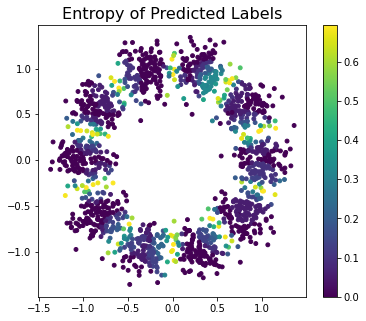

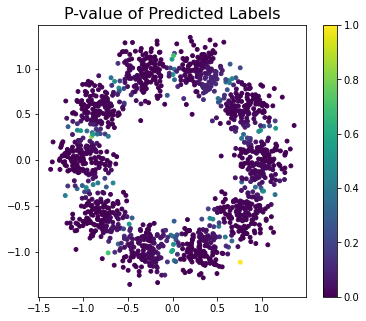

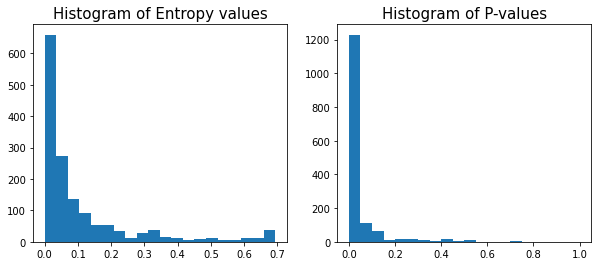

In [401]:
# Measures spread with Monte Carlo verification
monte_carlo_labels_gmm = monte_carlo_verification(mapped_labels_k_unknown, Aff_gmm, fire_temp_gmm, num_permute=100)
# Colors/values give uncertainty estimate for each point
e_gmm = display_entropy(monte_carlo_labels_gmm, coords_gmm, return_entropy=True)
p_gmm = display_p_values(monte_carlo_labels_gmm, mapped_labels_k_known, coords_gmm, return_pvals=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.set_title('Histogram of Entropy values', fontsize=15)
ax1.hist(e_gmm, bins=20)

ax2.set_title('Histogram of P-values', fontsize=15)
ax2.hist(p_gmm, bins=20)
plt.show()


In [22]:
unstable_idx = np.argwhere(e_gmm>0.2).reshape(-1)
print_alternate_clusters(mapped_labels_k_known, monte_carlo_labels_gmm, unstable_idx)

13 unstable points originally labeled in Cluster #0
  - 58% of different labelings to Cluster #1
  - 42% of different labelings to Cluster #9
--------------------
48 unstable points originally labeled in Cluster #1
  - 7% of different labelings to Cluster #0
  - 93% of different labelings to Cluster #2
--------------------
45 unstable points originally labeled in Cluster #2
  - 62% of different labelings to Cluster #1
  - 38% of different labelings to Cluster #3
--------------------
36 unstable points originally labeled in Cluster #3
  - 100% of different labelings to Cluster #2
--------------------
105 unstable points originally labeled in Cluster #4
  - 77% of different labelings to Cluster #3
  - 23% of different labelings to Cluster #5
--------------------
130 unstable points originally labeled in Cluster #5
  - 77% of different labelings to Cluster #4
  - 23% of different labelings to Cluster #6
--------------------
131 unstable points originally labeled in Cluster #6
  - 87% of d

Unstable cluster shown in black.
In Monte Carlo, the point marked with a star was frequently labeled in cluster shown in orange.
All other clusters shown in blue.


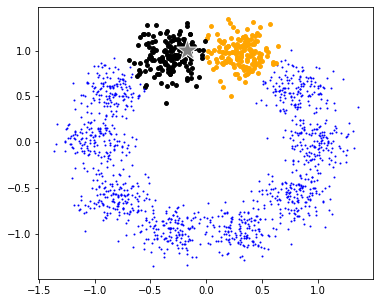

In [54]:
unstable_clusters, counts = np.unique(mapped_labels_k_known[unstable_idx], return_counts=True)
# clusters, counts = np.unique(mapped_labels_k_known, return_counts=True)
most_unstable_cluster = unstable_clusters[np.argmax(counts)]

# Make plot of largest clusters and smaller clusters that map to it
in_largest = mapped_labels_k_known==most_unstable_cluster
unstable_idx = np.argwhere((e_gmm > 0.2) & in_largest).reshape(-1)

display_alternate_clusters(mapped_labels_k_known, most_unstable_cluster, unstable_idx, monte_carlo_labels_gmm, coords_gmm)


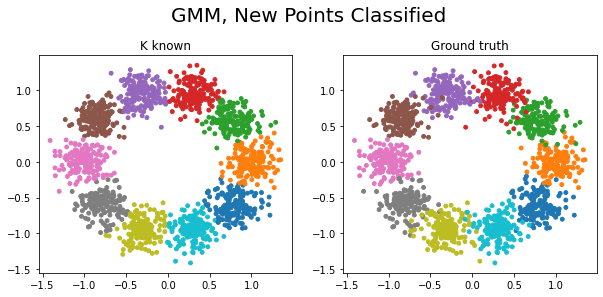

In [227]:
# Clusters new points to existing Gaussian Mixture Model
new_coords_gmm, _ = build_blobs(100, k_gmm, sigma=0.15)
mapped_new_labels, Aff_new = cluster_new_points(coords_gmm, new_coords_gmm, mapped_labels_k_known, fire_temp_gmm, kernel_type='gaussian', sigma_affinity=0.1)

all_coords_new = np.concatenate((coords_gmm, new_coords_gmm))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
title = fig.suptitle('GMM, New Points Classified', fontsize=20)
title.set_position([.5, 1.05])
ax1.scatter(all_coords_new[:,0], all_coords_new[:,1], c=mapped_new_labels, cmap='tab10', s=15)
ax1.set_title('K known')
ax2.scatter(coords_gmm[:,0], coords_gmm[:,1], c=gt_gmm, cmap='tab10', s=15)
ax2.set_title('Ground truth')
plt.show()

Loading dataset


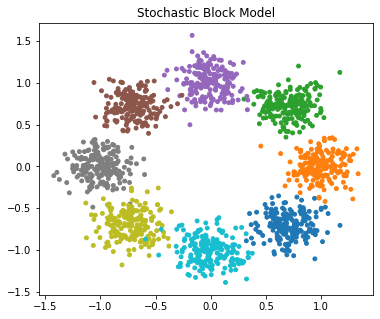

In [403]:
# Creates or loads coordinate data
k_sbm = 8
N_sbm = 1500
pij = .1
pii = .5

path = 'Datasets/SBM/' + str(k_sbm) + '_clusters_' + str(N_sbm) + '_pij_' + str(pij) + '_pii_' + str(pii) + '/'
coords_name = path + 'coords.npy'
gt_name = path + 'gt.npy'
A_name = path + 'A.npy'
if os.path.exists(coords_name) and os.path.exists(gt_name) and os.path.exists(A_name):
        print('Loading dataset')
        coords_sbm = np.load(coords_name)
        gt_sbm = np.load(gt_name)
        D_sbm = np.load(D_name)
        Adj_sbm = np.load(A_name)
else:
    # Make dataset with 3 clusters
    print('Constructing Gaussian Mixture Model with %d points and %d clusters' % (N_sbm, k_sbm))    
    Adj_sbm, gt_sbm, coords_sbm = build_sbm(N_sbm, k_sbm, pij, pii, sigma=.15)

    # Saves
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    with open(coords_name, 'wb') as f1:
        np.save(f1, coords_sbm)
    with open(gt_name, 'wb') as f2:
        np.save(f2, gt_sbm)
    with open(A_name, 'wb') as f3:
        np.save(f3, Adj_sbm)

plt.title('Stochastic Block Model')
plt.scatter(coords_sbm[:,0],coords_sbm[:,1], c=gt_sbm, cmap='tab10', s=15)
plt.show()

Burning clusters, true k known

Burning clusters, true k unknown


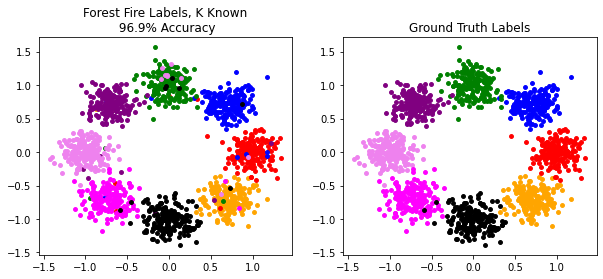

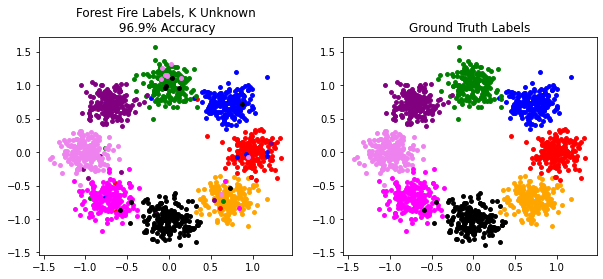

In [408]:
# Clusters graphical data
# N=1500, k=8: fire_temp=.1; pij=.025, pii=.25
# N=1500, k=8: fire_temp=.01; pij=.1, pii=.5
title = None#'Stochastic Block Model'
print('Burning clusters, true k known')

fire_temp_sbm = .01
labels_k_known_sbm = forest_fire_clustering(Adj_sbm, fire_temp_sbm, k=k_sbm)
mapped_labels_k_known_sbm = align_labels(gt_sbm, labels_k_known_sbm)

print('\nBurning clusters, true k unknown')
labels_k_unknown_sbm = forest_fire_clustering(Adj_sbm, fire_temp_sbm, min_cluster_size=30)
mapped_labels_k_unknown_sbm = align_labels(gt_sbm, labels_k_unknown_sbm)

display_outputs_and_gt(coords_sbm, gt_sbm, mapped_labels_k_known_sbm, k_known=True, title=title)
display_outputs_and_gt(coords_sbm, gt_sbm, mapped_labels_k_unknown_sbm, k_known=False)


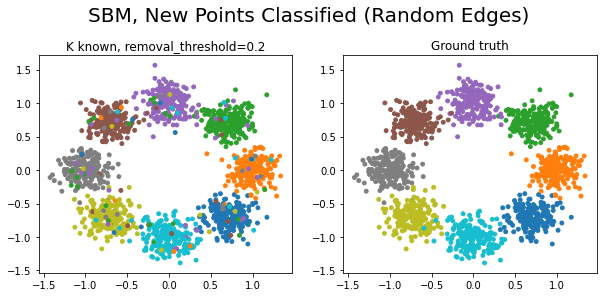

In [230]:
# Clusters 100 new points to existing Stochastic Block Model
Adj_sbm_new, _, coords_sbm_new = build_sbm(100, k_sbm, pij, pii, sigma=.15)
new_adjacencies = np.random.randint(2, size=(100, N_sbm))# Random edges with probability 0.5
mapped_new_labels_sbm, Adj_new = cluster_new_points(Adj_sbm, new_adjacencies, mapped_labels_k_known_sbm, fire_temp_sbm, interconnections=Adj_sbm_new)
all_coords_new_sbm = np.concatenate((coords_sbm, coords_sbm_new))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
title = fig.suptitle('SBM, New Points Classified (Random Edges)', fontsize=20)
title.set_position([.5, 1.05])
ax1.scatter(all_coords_new_sbm[:,0], all_coords_new_sbm[:,1], c=mapped_new_labels_sbm, cmap='tab10',s=15)
ax1.set_title('K known')
ax2.scatter(coords_sbm[:,0], coords_sbm[:,1], c=gt_sbm, cmap='tab10',s=15)
ax2.set_title('Ground truth')
plt.show()


Iteration 10/100. Time elapsed: 6.73 seconds
Iteration 20/100. Time elapsed: 13.54 seconds
Iteration 30/100. Time elapsed: 21.05 seconds
Iteration 40/100. Time elapsed: 27.59 seconds
Iteration 50/100. Time elapsed: 34.17 seconds
Iteration 60/100. Time elapsed: 41.26 seconds
Iteration 70/100. Time elapsed: 47.87 seconds
Iteration 80/100. Time elapsed: 55.47 seconds
Iteration 90/100. Time elapsed: 63.5 seconds


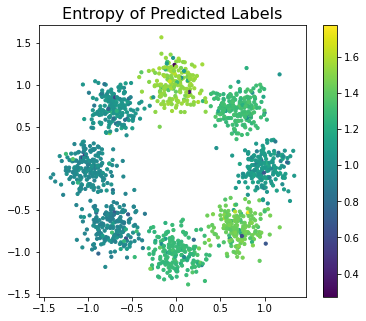

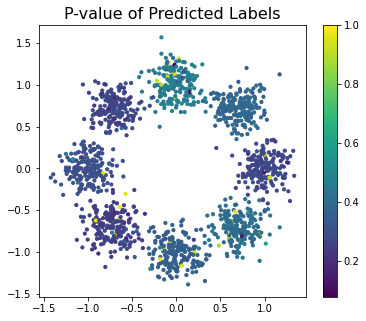

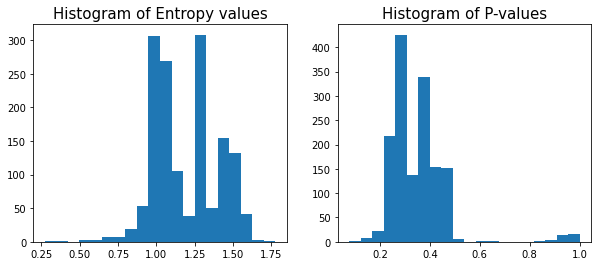

In [231]:
monte_carlo_labels_sbm = monte_carlo_verification(mapped_labels_k_known_sbm, Adj_sbm, fire_temp_sbm, num_permute=100)
e_sbm = display_entropy(monte_carlo_labels_sbm, coords_sbm, return_entropy=True)
p_sbm = display_p_values(monte_carlo_labels_sbm, mapped_labels_k_known_sbm, coords_sbm, return_pvals=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.set_title('Histogram of Entropy values', fontsize=15)
ax1.hist(e_sbm, bins=20)

ax2.set_title('Histogram of P-values', fontsize=15)
ax2.hist(p_sbm, bins=20)
plt.show()

In [233]:
unstable_idx_sbm = np.argwhere(e_sbm>1.3).reshape(-1)
print_alternate_clusters(mapped_labels_k_known_sbm, monte_carlo_labels_sbm, unstable_idx_sbm)


170 unstable points originally labeled in Cluster #0
  - 8% of different labelings to Cluster #1
  - 15% of different labelings to Cluster #2
  - 12% of different labelings to Cluster #3
  - 12% of different labelings to Cluster #4
  - 17% of different labelings to Cluster #5
  - 10% of different labelings to Cluster #6
  - 26% of different labelings to Cluster #7
--------------------
2 unstable points originally labeled in Cluster #1
  - 27% of different labelings to Cluster #0
  - 8% of different labelings to Cluster #2
  - 37% of different labelings to Cluster #3
  - 5% of different labelings to Cluster #4
  - 5% of different labelings to Cluster #5
  - 5% of different labelings to Cluster #6
  - 12% of different labelings to Cluster #7
--------------------
126 unstable points originally labeled in Cluster #2
  - 9% of different labelings to Cluster #0
  - 6% of different labelings to Cluster #1
  - 39% of different labelings to Cluster #3
  - 10% of different labelings to Cluster #

In [17]:
def louvain(A, resolution):
    N = A.shape[0]
    # Builds graph
    G = nx.Graph()
    G.add_nodes_from(np.arange(N))
    adjacency = np.array_equal([0,1], np.unique(X))

    # Makes tuple of all graph edges
    if adjacency:
        # Edges from adjacency matrix
        edges = tuple(map(tuple, np.argwhere(A)))
        G.add_edges_from(edges)# Each pair of points and whether or not they share an edge
    else:
        # weighted edges from affinity matrix
        indices_list = np.argwhere(np.ones((N,N))) # Indices for each pair of points
        values_list = A.flatten() # Values
        edges = tuple(zip(indices_list[:,0],indices_list[:,1], values_list))# Each pair of points and its affinity
        G.add_weighted_edges_from(edges)

    # Partitions with Louvain algorithm
    partition = community_louvain.best_partition(G, resolution=resolution)
    louvain_clusters = np.array(list(partition.values()))
    return louvain_clusters


In [18]:
# Creates or loads coordinate data
k_gmm = 10
n_samples = 1500

path = 'Datasets/gmm_benchmark/'
coords_name = path + 'coords.npy'
gt_name = path + 'gt.npy'
D_name = path + 'D.npy'
A_name = path + 'A.npy'
if os.path.exists(coords_name) and os.path.exists(gt_name) and os.path.exists(D_name) and os.path.exists(A_name):
        print('Loading dataset')
        coords_gmm = np.load(coords_name)
        gt_gmm = np.load(gt_name)
else:
    print('Constructing Gaussian Mixture Model with %d points and %d clusters' % (n_samples, k_gmm))
    coords_gmm, gt_gmm = build_blobs(N_gmm, k_gmm, sigma=0.15)    

    # Saves
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)
    with open(coords_name, 'wb') as f1:
        np.save(f1, coords_gmm)
    with open(gt_name, 'wb') as f2:
        np.save(f2, gt_gmm)


Constructing Gaussian Mixture Model with 1500 points and 10 clusters


In [19]:
# save datasets and labels
Dir = 'Datasets/'
if not os.path.exists(Dir+'noisy_circles/'):
    os.mkdir(Dir+'noisy_circles/')
if not os.path.exists(Dir+'noisy_moons/'):
    os.mkdir(Dir+'noisy_moons/')
if not os.path.exists(Dir+'varied/'):
    os.mkdir(Dir+'varied/')
if not os.path.exists(Dir+'aniso/'):
    os.mkdir(Dir+'aniso/')
if not os.path.exists(Dir+'blobs/'):
    os.mkdir(Dir+'blobs/')
if not os.path.exists(Dir+'gmm_benchmark/'):
    os.mkdir(Dir+'gmm_benchmark/')


Automatically created module for IPython interactive environment


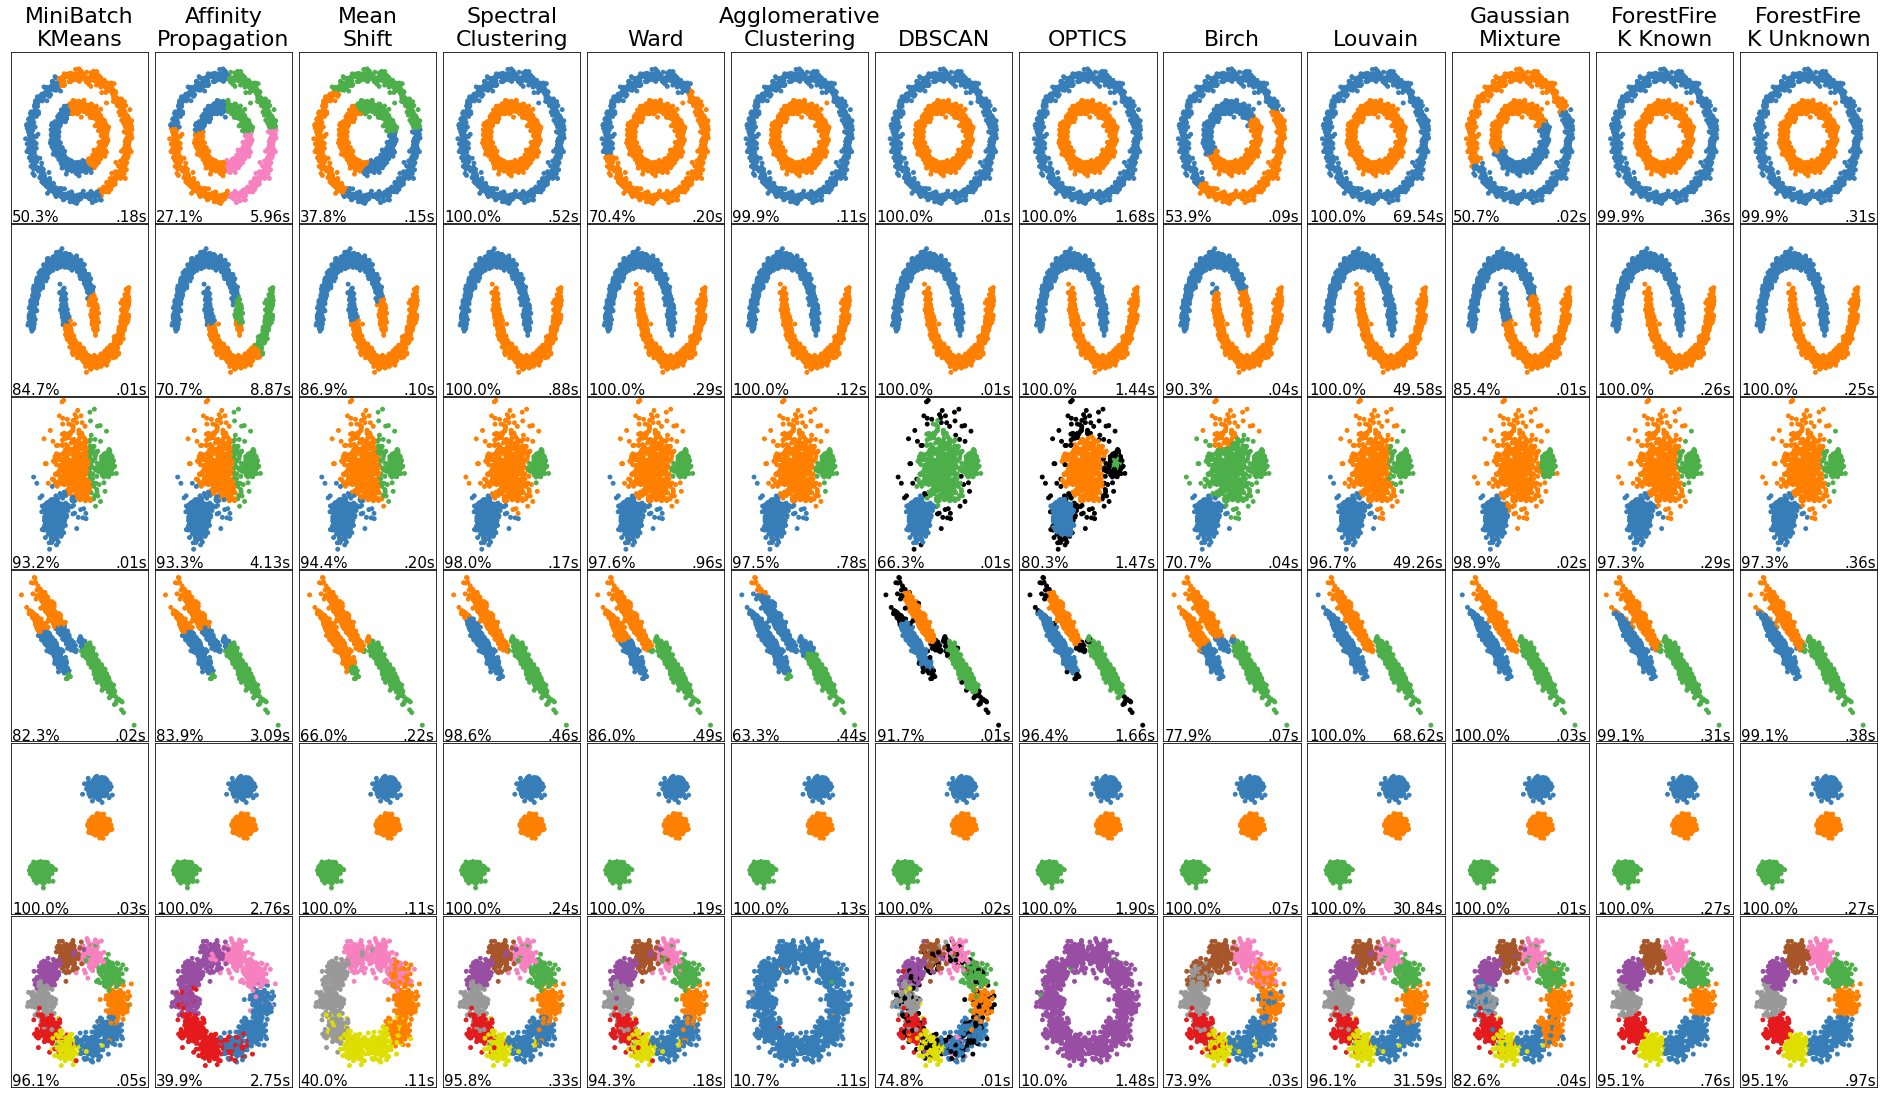

In [76]:
print(__doc__)

np.random.seed(0)
n_samples = 1500

# All datasets are (X, y) where X is n_samples x 2 dimensions
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)# Concentric circles
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)# horizontal moons
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)# Three blobs
# no_structure = np.random.rand(n_samples, 2), None# full rectangle

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# 3 blobs with 3 different variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

gmm_data = (coords_gmm, gt_gmm)
toy_datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (gmm_data, {'n_clusters': k_gmm, 'eps':.08, 'min_samples':5})
]

# Initialize image
plt.figure(figsize=(12*2 + 3, len(toy_datasets)*2.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1


for i_dataset, (dataset, algo_params) in enumerate(toy_datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    # all x and y between -2 and 2, roughly
    X = StandardScaler().fit_transform(X)
    
    # Save dataset
    if i_dataset==0:
        path = 'Datasets/noisy_circles/'
    if i_dataset==1:
        path = 'Datasets/noisy_moons/'
    if i_dataset==2:
        path = 'Datasets/varied/'
    if i_dataset==3:
        path = 'Datasets/aniso/'
    if i_dataset==4:
        path = 'Datasets/blobs/'
    if i_dataset==5:
        path = 'Datasets/gmm_benchmark/'
    np.save(path+'coords.npy', X)
    np.save(path+'gt.npy', y)
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'], 
                            min_samples=params['min_samples'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'], eps=params['eps'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),# Slow and ineffective
        ('Mean\nShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch), # Ineffective
        ('Louvain', louvain), # Slow
        ('Gaussian\nMixture', gmm),
        ('ForestFire\nK Known', forest_fire_clustering),
        ('ForestFire\nK Unknown', forest_fire_clustering)
    )

    for name, algorithm in clustering_algorithms:
        clean_name = name.replace('\n', ' ').replace(' ', '_')
        labels_path = path+clean_name+'.npy'
        runtime_path = path+clean_name+'_runtime.npy'
        if os.path.exists(labels_path) and 'ForestFire' not in name:
            # Loads data
            y_pred = np.load(labels_path)
            runtime = np.load(runtime_path)[0]
        else:
            t0 = time.time()

            # catch warnings related to kneighbors_graph
            with warnings.catch_warnings():
                warnings.filterwarnings(
                    "ignore",
                    message="the number of connected components of the " +
                    "connectivity matrix is [0-9]{1,2}" +
                    " > 1. Completing it to avoid stopping the tree early.",
                    category=UserWarning)
                warnings.filterwarnings(
                    "ignore",
                    message="Graph is not fully connected, spectral embedding" +
                    " may not work as expected.",
                    category=UserWarning)

                if name in ['ForestFire\nK Known', 'ForestFire\nK Unknown', 'Louvain']:
                    last = len(toy_datasets)-1
                    dist = compute_distance_matrix(X)
                    affin = compute_affinity_matrix(dist, k=10)
                    if name=='Louvain':
                        resolution = 1 if i_dataset==5 else 10
                        y_pred = louvain(affin, resolution)
                    else:
                        # Previously: i_dataset=.75 for 0,1,3,4; .1 for 2 and 5
                        if i_dataset in [0,1,4]:# Circles, moons, and blobs
                            fire_temp = 1
                        elif i_dataset==2:# Varied
                            fire_temp = .2
                        elif i_dataset==3:# Aniso
                            fire_temp = .25
                        else:
                            fire_temp = .05# Gaussians
                        
                        if name=='ForestFire\nK Known':
                            y_pred = forest_fire_clustering(affin, fire_temp, k=params['n_clusters'])
                        else:
                            y_pred = forest_fire_clustering(affin, fire_temp, min_cluster_size=50)
                else:
                    algorithm.fit(X)

            if name not in ['ForestFire\nK Known', 'ForestFire\nK Unknown', 'Louvain']:
                if hasattr(algorithm, 'labels_'):
                    y_pred = algorithm.labels_.astype(int)
                else:
                    y_pred = algorithm.predict(X)


            t1 = time.time()
            runtime = t1-t0
            np.save(runtime_path, np.array([runtime]))
            np.save(labels_path, y_pred)
        
        k_model = np.unique(y_pred).shape[0]
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      max(k_model, params['n_clusters']))))
        
        if -1 not in np.unique(y_pred):        
            y_pred_mapped = align_labels(y, y_pred)
            pct_accuracy = 100*np.sum(y_pred_mapped==y)/n_samples
        else:
            # Map everything except -1 indices
            y_pred_shifted = remap(y_pred)
            y_pred_mapped = align_labels(y, y_pred_shifted)
            pct_accuracy = 100*np.sum((y_pred_mapped==y) & (y_pred != -1))/n_samples
            
            # add black color for outliers
            y_pred_mapped[y_pred==-1] = k_model
            colors = np.append(colors, ["#000000"])

        
        plt.subplot(len(toy_datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=22)

        plt.scatter(X[:, 0], X[:, 1], s=15, color=colors[y_pred_mapped])
        if i_dataset==2:
            plt.xlim(-3, 3)
            plt.ylim(-3, 3)
        elif i_dataset==3:
            plt.xlim(-2.5, 3.5)
            plt.ylim(-4, 3)
        else:
            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % runtime).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        
        plt.text(.01, .01, '{}%'.format(round(pct_accuracy,1)), 
                 transform=plt.gca().transAxes, 
                 size=15, horizontalalignment='left')
        plot_num += 1
        

plt.show()
